## 尝试复现deepsigns 水印嵌入方法

In [1]:
#加载模型并获取dataloader
from tools.import_model import trmodel
from attack.CW import CWAttack
import numpy as np # type: ignore
import cv2# type: ignore
import torchattacks # type: ignore
import argparse
import pathlib
import time
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import PIL.Image # type: ignore
import torch.nn.functional as F # type: ignore
import sys
sys.argv = ['run.py']

try:
    import apex
except ImportError:
    pass
import numpy as np # type: ignore
import torch# type: ignore
import torch.nn as nn # type: ignore
import torch.distributed as dist# type: ignore
import torchvision# type: ignore
import cv2# type: ignore

from fvcore.common.checkpoint import Checkpointer# type: ignore

from pytorch_image_classification import (
    apply_data_parallel_wrapper,
    create_dataloader,
    create_loss,
    create_model,
    create_optimizer,
    create_scheduler,
    get_default_config,
    update_config,
)
from pytorch_image_classification.config.config_node import ConfigNode
from pytorch_image_classification.utils import (
    AverageMeter,
    DummyWriter,
    compute_accuracy,
    count_op,
    create_logger,
    create_tensorboard_writer,
    find_config_diff,
    get_env_info,
    get_rank,
    save_config,
    set_seed,
    setup_cudnn,
)
from pytorch_image_classification import (
    get_default_config,
    create_model,
    create_transform,
)
import torch.nn.functional as F
import copy


2024-12-28 21:36:18.892023: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-28 21:36:18.943346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-28 21:36:19.697908: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
cfg_path = './configs/self_dataset/resnet.yaml'
pth_path = './experiments/mnist/resnet/exp06/checkpoint_00160.pth'

#水印嵌入模型仍为resnet110
model = trmodel(cfg_path,pth_path).get_model().to(torch.device("cuda:0"))
model #展示模型的主要框架

Network(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage1): Sequential(
    (block1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (block2): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1

In [3]:
def load_config():
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str,default = '/root/ZYM/zym/AI_S/torch_classification/configs/self_dataset/resnet.yaml' )
    parser.add_argument('--resume', type=str, default='')
    parser.add_argument('--local_rank', type=int, default=0)
    parser.add_argument('options', default=None, nargs=argparse.REMAINDER)
    args = parser.parse_args()

    config = get_default_config()
    if args.config is not None:
        config.merge_from_file(args.config)
    config.merge_from_list(args.options)
    if not torch.cuda.is_available():
        config.device = 'cpu'
        config.train.dataloader.pin_memory = False
    if args.resume != '':
        config_path = pathlib.Path(args.resume) / 'config.yaml'
        config.merge_from_file(config_path.as_posix())
        config.merge_from_list(['train.resume', True])
    config.merge_from_list(['train.dist.local_rank', args.local_rank])
    config = update_config(config)
    config.freeze()
    return config

config = load_config()
set_seed(config)
setup_cudnn(config)
from pytorch_image_classification.datasets.datasets_custom import create_dataset
_dataset = create_dataset(config, is_train = True)[0] #水印训练数据集，从训练集中挑选总数据集的1%，即600张

self_maede_dataset


In [4]:
from torch.utils.data import Subset, DataLoader, random_split
num_samples = int(len(_dataset) * 0.01) 
indices = torch.randperm(len(_dataset))[:num_samples]
wm_dataset = Subset(_dataset, indices)
wm_dataloader = DataLoader(wm_dataset, batch_size=32, shuffle=True)

In [5]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, layer_name):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.layer_name = layer_name
        self.feature = None
        self._register_hook()

    def _register_hook(self):
        def hook(module, input, output):
            self.feature = output.detach()
        
        for name, module in self.model.named_modules():
            if name == self.layer_name:
                module.register_forward_hook(hook)
    def forward(self, x):
        self.model.eval()
        _ = self.model(x)
        return self.feature


In [6]:
model.train()
feature_extractor = FeatureExtractor(model, layer_name='stage1.block3')
fs =  feature_extractor(wm_dataset[12][0].unsqueeze(0).to(torch.device("cuda:0"))).shape[1:] #在此处额外获取feature的形状,此处为元组type
from watermark import DeepSignsWatermark
target_layer = 'stage1.block3'
deepsigns = DeepSignsWatermark(model,wm_dataloader,target_layer)
watermarked_model = deepsigns.wm_train(feature_shape= fs)

Retaining Epoch :   0%|          | 0/6 [00:00<?, ?it/s]/root/miniconda3/envs/zym38/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Retaining Epoch : 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]


In [7]:
test_dataset = create_dataset(config, is_train = False) #获取测试数据集
testloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                             batch_size=512,
                                             shuffle=False)
watermarked_model.eval()
loss_meter = 0
acc_meter = 0
with torch.no_grad():
    for d, t in testloader:
        data = d.to(torch.device("cuda:0"))
        target = t.to(torch.device("cuda:0"))
        pred = watermarked_model(data)
        loss_meter += F.cross_entropy(pred, target, reduction='sum').item()
        pred = pred.max(1, keepdim=True)[1]
        acc_meter += pred.eq(target.view_as(pred)).sum().item()
#测试嵌入水印后模型的性能是否受到影响
print('Test loss:', loss_meter / len(testloader.dataset))
print('Test accuracy:', acc_meter / len(testloader.dataset))

self_maede_dataset


Test loss: 0.03120032742023468
Test accuracy: 0.9915


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


watered marked 16 bit: [0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0]


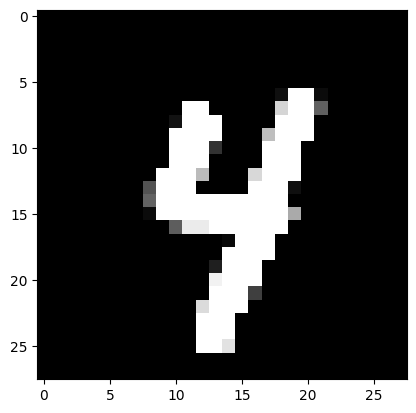

In [77]:
#验证水印提取能力并测试对应BER（Bite Error Rate）
b = deepsigns.b
print("watered marked 16 bit:",(deepsigns.b[:,4]))
test_instance = test_dataset[4815][0]
plt.figure()
img_show = test_instance.cpu().numpy().transpose(1,2,0)
plt.imshow(img_show)
plt.show()


In [79]:
watermarked_model.eval()
marked_activations_extractor =   FeatureExtractor(watermarked_model, layer_name='stage1.block3')
test_feature = marked_activations_extractor(test_instance.unsqueeze(0).to(torch.device("cuda:0")))
A = np.load('/root/ZYM/zym/AI_S/torch_classification/watermark/projection_matrix.npy')
A_tensor = torch.tensor(A).to("cuda:0").view(16,-1)
feature = torch.mean(test_feature,dim = 0).view(-1,1).double()
bit_test = torch.sigmoid(torch.matmul(A_tensor,feature.to("cuda:0")).squeeze())

In [92]:
X_Ck_sigmoid = 1 / (1 + np.exp(bit_test.cpu().numpy()))
raw_bit = deepsigns.b[:,7]
decode_wmark = (X_Ck_sigmoid > 0.45) * 1
raw_bit,decode_wmark

(array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]),
 array([0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]))

根据以上结果可以看出，虽然水印已被嵌入，但在BSR上仍有较大的提升空间

上述的水印植入class，具体代码如下：

In [ ]:
import numpy as np # type: ignore
import sys
sys.argv = ['run.py']

import torch# type: ignore
import cv2# type: ignore

import torch.nn.functional as F
import copy
from tqdm import trange,tqdm


class DeepSignsWatermark:
    def __init__(self,model,dataloader,layer_name):
        self.device = torch.device("cuda:0")
        self.model = model.to(self.device)
        self.dataloader = dataloader
        self.lr = 0.001
        self.epochs = 5
        self.scale = 0.01 #for loss1
        self.gamma = 0.01 #for loss2
        self.embed_bits = 16 #the length of watermark
        self.save_path = "/root/ZYM/zym/AI_S/torch_classification/watermark/projection_matrix.npy"
        self.n_classes = 10
        self.b = np.random.randint(2, size=(self.embed_bits, self.n_classes))
        self.feature_layer = layer_name
        self.centers = None
        self.feature = None
        self.target_class = 0
        self._register_hook()

    def _register_hook(self):
        def hook(module, input, output):
            self.feature = output.detach()
            #print(f"Feature captured: {self.feature.shape}")  # Debugging line

        for name, module in self.model.named_modules():
            if name == self.feature_layer:
                module.register_forward_hook(hook)
                #print(f"Hook registered to layer: {name}")  # Debugging line

    def wm_train(self,feature_shape):
        self.model.train()
        self.centers = torch.nn.Parameter(torch.rand(self.n_classes, *feature_shape).to(self.device), requires_grad=True)
        centers = self.centers
        device = self.device
        optimizer = torch.optim.RMSprop([
        {'params': self.model.parameters()},
        {'params': centers}
        ], alpha=0.9, lr=self.lr, eps=1e-8,
        weight_decay=0.001) 
        criterion = torch.nn.CrossEntropyLoss().cuda()
        x_value = np.random.randn(self.embed_bits, *feature_shape) #产生一个投影向量
        np.save(self.save_path,x_value)
        x_value = torch.tensor(x_value, dtype=torch.float32).to(device)#转换为torch
        b = torch.tensor(self.b).to(self.device)
        for ep in tqdm(range(self.epochs+1),desc="Retaining Epoch "):
            #print(ep)
            for d,t in self.dataloader:
                d = d.to(device)
                t = t.to(device)
                optimizer.zero_grad()
                pred = self.model(d)
                feat = copy.deepcopy(self.feature).to(device)
                loss = criterion(pred,t)
                centers_batch = torch.index_select(centers, 0, t)
                #centers初始化过程中为随机生成,但仍然满足不同类别数据GMM分布的定义
                loss1 = F.mse_loss(feat, centers_batch, reduction='sum') / 2
                centers_batch_reshape = torch.unsqueeze(centers_batch, 1)
                centers_reshape = torch.unsqueeze(centers, 0)
                pairwise_dists = (centers_batch_reshape - centers_reshape) ** 2
                pairwise_dists = torch.sum(pairwise_dists, dim=(-3,-2,-1))
                arg = torch.topk(-pairwise_dists, k=2)[1]
                arg = arg[:, -1]
                closest_cents = torch.gather(centers, 0, arg.unsqueeze(1).unsqueeze(2).unsqueeze(3).repeat(1, feat.shape[1],feat.shape[2],feat.shape[3]))
                #closest_cents = torch.gather(centers, 0, arg.unsqueeze(1).repeat(1, feat.shape[1]))
                dists = torch.sum((centers_batch - closest_cents) ** 2, dim=(-3,-2,-1))
                cosines = torch.mul(closest_cents, centers_batch)
                cosines = torch.sum(cosines, dim=(-3,-2,-1))
                loss2 = (cosines * dists - dists).mean()
                loss3 = (1 - torch.sum(centers ** 2, dim=(1,2,3))).abs().sum()
                loss4 = 0
                embed_center_idx = self.target_class
                idx_classK = (t == embed_center_idx).nonzero(as_tuple=True)
                if len(idx_classK[0]) >= 1:
                    idx_classK = idx_classK[0]
                    
                    #activ_classK = torch.gather(centers_batch, 0,idx_classK.unsqueeze(1).unsqueeze(2).unsqueeze(3).repeat(1, feat.shape[1],feat.shape[2],feat.shape[3]))
                    activ_classK_2 = []
                    index_list = idx_classK.detach().cpu().numpy()
                    centers_batch_numpy = centers_batch.detach().cpu().numpy()
                    for index in index_list:
                        activ_classK_2.append(centers_batch_numpy[index])
                    activ_classK_2_numpy = np.array(activ_classK_2)
                    #将 NumPy 数组转换为 PyTorch 张量
                    activ_classK_2_tensor = torch.tensor(activ_classK_2_numpy).to(self.device)
                    center_classK = torch.mean(activ_classK_2_tensor, dim=0)
                    center_classK = center_classK.view(-1,1)
                    x_value = x_value.view(16,-1)
                    Xc = torch.matmul(x_value, center_classK)
                    Xc = Xc.squeeze()
                    bk = b[:, embed_center_idx]
                    bk_float = bk.float()
                    probs = torch.sigmoid(Xc)
                    entropy_tensor = F.binary_cross_entropy(target=bk_float, input=probs, reduce=False)
                    loss4 += entropy_tensor.sum()
                (loss + self.scale * (loss1 + loss2 + loss3) + self.gamma * loss4).backward()
                optimizer.step()
        return copy.deepcopy(self.model.to(device))